In [10]:
import pandas as pd
import numpy as np
from SimilarityDetectModel import ComputeSimilarity,ComputeEuclideanDistance,ComputeDTWDistance,ComputeCosineSimilarity,ComputeFrechetDistance,ComputeHausdorffDistance,ComputeLongestCommonSubsequenceSimilarity
import matplotlib.pyplot as plt
from ConvertChineseToPinyin import convert_to_pinyin_initials
from pypinyin import pinyin, Style
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = 'plotly_white'
plot_template = dict(
    layout=go.Layout({
        'font_size': 8,
        'xaxis_title_font_size': 8,
        'yaxis_title_font_size': 8,
        }   
))
import matplotlib.pyplot as plt
hydro_stations = ['Tangnaihai','Guide','Xunhua']
# read observed climate data
hydrostation_metestations = {
    'Tangnaihai': [
        '玛多', '达日', '久治', '红原', '若尔盖', '玛曲', '玛沁', '河南', '兴海',
    ],
    'Guide': [
        '玛多', '达日', '久治', '红原', '若尔盖', '玛曲', '玛沁', '河南', '兴海',
        '贵南', '共和', '贵德',
    ],
    'Xunhua': [
        '玛多', '达日', '久治', '红原', '若尔盖', '玛曲', '玛沁', '河南', '兴海',
        '贵南', '共和', '贵德', '同仁',
    ]
}
metestation_statyear_dict = {
    '玛多':1957,
    '达日':1956,
    '久治':1959,
    '红原':1961,
    '若尔盖':1959,
    '玛曲':1969,
    '玛沁':1959,
    '河南':1960,
    '兴海':1960,
    '贵南':1960,
    '共和':1955,
    '贵德':1959,
    '同仁':1960,
}
# !station_names = [ # all
#     '玛多',# 1957-2019
#     '达日',# 1956-2019
#     # '甘德',
#     '久治',# 1958-2019
#     '红原',#1960-2019
#     '若尔盖',#1959-2019
#     '玛曲',#1969-2019
#     '玛沁',#1959-2019
#     '河南',#1959-2019
#     # '泽库',
#     # '同德',
#     '兴海',#1960-2019
#     '贵南',#1960-2019
#     '共和',#1955-2019
#     '贵德',#1959-2019
#     '同仁',#1960-2019
# ]


1 评估各水文站汛期开始时间

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


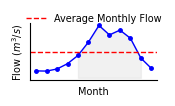

In [11]:
for hydro_station in hydro_stations:
    monthly_flow = pd.read_csv(f'../data/{hydro_station.lower()}_natural_monthly_flow.csv',parse_dates=['date'],index_col=['date'])
    monthly_flow
    # 添加月份列
    monthly_flow['month'] = monthly_flow.index.month
    # get the average the monthlyflow
    monthly_flow_avg = monthly_flow['flow(m^3/s)'].mean()
    # 计算每个月的多年平均值
    monthly_avg = monthly_flow.groupby('month')['flow(m^3/s)'].mean()
    # Visualize the month monthly_avg
    fig = px.line(monthly_avg, title=f'Multi-Year Average Monthly Flow at {hydro_station}')
    # Add a horizontal line
    fig.add_shape(
        type='line',
        x0=0,
        y0=monthly_flow_avg,
        x1=12,
        y1=monthly_flow_avg,
        line=dict(
            color='Red',
            width=2,
            dash='dashdot',
        ),
        name='Horizontal Line'
    )
    fig.show()
    # Plot the avergae monthly flow
    if hydro_station == 'Tangnaihai':
        font_size = 7
        plt.figure(figsize=(1.5, 0.8))
        plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-', color='b',linewidth=1,markersize=2.5)
        plt.axhline(y=monthly_flow_avg, color='r', linestyle='--', label='Average Monthly Flow',linewidth=1)
        # 填充5月到11月之间的区域
        plt.fill_between(monthly_avg.index[4:11], 0, monthly_avg.values[4:11], color='lightgray', alpha=0.3)
        plt.xlabel('Month', fontsize=font_size)
        plt.ylabel('Flow ($m^3/s$)', fontsize=font_size)
        plt.xticks(fontsize=font_size)
        plt.yticks(fontsize=font_size)
        # set the scientific notation
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
        plt.gca().yaxis.get_offset_text().set_fontsize(font_size) 
        plt.legend(fontsize=font_size,bbox_to_anchor=(0.5, 1.08), loc='center',frameon=False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        # invisible the ticks on y-axis
        plt.gca().tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
        plt.gca().tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        plt.subplots_adjust(left=0.115, right=0.96, top=0.88, bottom=0.16)
        plt.savefig(f'../figs/MultiYearAverageObservedFlow_minmap.png',format='png',dpi=300,transparent=True)
        plt.savefig(f'../figs/MultiYearAverageObservedFlow_minmap.eps',format='eps',dpi=1000,transparent=True)
        plt.show()


2 Get similarity year of each meteorological station based on the precipitation data in the catchment controled by Tangnaihai station at the Upper Reach of Yellow.

The meteorological stations include 玛多、达日、久治、红原、若尔盖、玛曲、河南、兴海


In [12]:
for hydro_station in hydro_stations:
    tar_years = np.arange(2014,2019)
    df_sim = pd.DataFrame(index=tar_years)
    df_sim.index.name = 'tar_year'
    start_month = '01'
    mete_station_names = hydrostation_metestations[hydro_station]
    for mete_station in mete_station_names:
        start_year = metestation_statyear_dict[mete_station]
        df = pd.read_csv('D:/DataSpace/HydroMeteAnthropicDatabase/7.FilledRawMeteObsInfo/ChinaLandDailyMeteV3(InsertSolarRadiation)/{}.csv'.format(mete_station),parse_dates=['DATE'],index_col=['DATE'])
        df_precp = df['P2020(mm)']
        df_precp = df.loc[f'{start_year}-01-01':,'P2020(mm)']
        df_precp = df_precp.resample('ME').sum()
        sim_years = []
        for tar_year in tar_years:
            # print(hydro_station,mete_station,tar_year)
            df_precp_tar = df_precp['{}-{}-01'.format(tar_year,start_month):'{}-12-31'.format(tar_year)]
            df_precp_ref = df_precp[:'{}-12-31'.format(tar_year-1)]
            sim_df, sim_year_dict = ComputeSimilarity(df_precp_tar,df_precp_ref)
            sim_years.append(sim_year_dict['Similarity Score'])
        df_sim[mete_station] = sim_years
    df_sim.to_csv(f'../result/MeteSimilarityYears_{hydro_station}.csv')
    df_sim


3. Get hydrological similarity years using historical monthly streamflow

In [13]:
forecast_years = np.arange(2015,2020)
for hydro_station in hydro_stations:
    df = pd.read_csv(f'../data/{hydro_station.lower()}_natural_monthly_flow.csv',parse_dates=['date'],index_col=['date'])
    df = df.loc['1969-01-01':,:]
    sim_years_df = pd.DataFrame(index=forecast_years,columns=['SimYear'])
    sim_years_df.index.name = 'PredYear'
    for forecast_year in forecast_years:
        target_year_flow = df.loc[f'{forecast_year-1}-01-01':f'{forecast_year-1}-12-31','flow(m^3/s)']
        ref_flow = df.loc[:f'{forecast_year-2}-12-31','flow(m^3/s)']
        sim_df,sim_year_dict= ComputeSimilarity(target_year_flow,ref_flow)
        sim_years_df.loc[forecast_year,'SimYear'] = sim_year_dict['Similarity Score']+1
    sim_years_df.to_csv(f'../result/SimilarityYears/{hydro_station.lower()}_hydrological_similiarity_year.csv')
    fig = go.Figure()
    for forecast_year in forecast_years:
        sim_year = sim_years_df.loc[forecast_year,'SimYear']
        obs_flow = df.loc[f'{forecast_year}-01-01':f'{forecast_year}-12-31','flow(m^3/s)']
        sim_year_flow = df.loc[f'{sim_year}-01-01':f'{sim_year}-12-31','flow(m^3/s)']
        sim_year_flow.index = obs_flow.index
        fig.add_trace(go.Scatter(x=obs_flow.index,y=obs_flow,mode='lines',name=f'{forecast_year}',line=dict(color='black')))
        fig.add_trace(go.Scatter(x=sim_year_flow.index,y=sim_year_flow,mode='lines',name=f'{sim_year}',line=dict(color='red')))
    fig.update_layout(title=f'{hydro_station} Monthly Streamflow from Similar Years',xaxis_title='Date',yaxis_title='Streamflow (m^3/s)')
    fig.show()



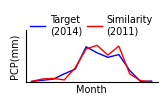

In [4]:
# droped; it was used to plot minimap
station_names = [ # Tangnaihai
    '玛多',# 1957-2019
    '达日',# 1956-2019
    # '甘德',
    '久治',# 1958-2019
    '红原',#1960-2019
    '若尔盖',#1959-2019
    '玛曲',#1969-2019
    '玛沁',#1959-2019
    '河南',#1959-2019
    # '泽库',
    # '同德',
    '兴海',#1960-2019
]

years = np.array([2014,2015, 2016, 2017, 2018]) # pred years 2015-2019

for station in station_names:
    df = pd.read_csv('D:/DataSpace/HydroMeteAnthropicDatabase/7.FilledRawMeteObsInfo/ChinaLandDailyMeteV3(InsertSolarRadiation)/{}.csv'.format(station),parse_dates=['DATE'],index_col=['DATE'])
    df_precp = df['P2020(mm)']
    if station=='久治':
        df_precp = df.loc['1959-01-1':,'P2020(mm)']
    elif station=='红原':
        df_precp = df.loc['1961-01-1':,'P2020(mm)']
    elif station=='河南':
        df_precp = df.loc['1960-01-1':,'P2020(mm)']
    df_precp = df_precp.resample('ME').sum()

    x = list(range(int(start_month),13))


    
    # fig, axs = plt.subplots(1, 5, figsize=(15, 8))
    # print(axs)

    for i in range(5):
        tar_year = years[i]
        ref_year = df_sim.loc[tar_year,station]
        # axs[i].plot(x,df_precp['{}-{}-01'.format(tar_year,start_month):'{}-12-31'.format(tar_year)].values,color='blue',label='target({})'.format(tar_year))
        # axs[i].plot(x,df_precp['{}-{}-01'.format(ref_year,start_month):'{}-12-31'.format(ref_year)].values,color='red',label='reference({})'.format(ref_year))
        # axs[i].set_xlabel('month')
        # axs[i].set_ylabel('Precipitation(mm)')
        # axs[i].set_title(convert_to_pinyin_initials(station))
        # axs[i].legend(fontsize=8,)

        ###!# plot minimap for similarity year====start
        if station=='玛多' and tar_year==2014:
            # Plot the avergae monthly flow
            font_size = 7
            plt.figure(figsize=(1.5, 0.8))
            plt.plot(x,df_precp['{}-{}-01'.format(tar_year,start_month):'{}-12-31'.format(tar_year)].values,color='blue',label='Target\n({})'.format(tar_year),linewidth=1)
            plt.plot(x,df_precp['{}-{}-01'.format(ref_year,start_month):'{}-12-31'.format(ref_year)].values,color='red',label='Similarity\n({})'.format(ref_year),linewidth=1)
            plt.xlabel('Month', fontsize=font_size, labelpad=2)
            plt.ylabel('PCP(mm)', fontsize=font_size)
            plt.xticks(fontsize=font_size-1)
            plt.yticks(fontsize=font_size)
            plt.legend(fontsize=font_size,bbox_to_anchor=(0.5, 1.08), loc='center',frameon=False,ncol=2,
                       columnspacing=0.5,
                       handlelength=1.5,
                       handletextpad=0.5,
                       borderaxespad=0.5,
                       borderpad=0.5,
                        labelspacing=0.5,)
            plt.gca().spines['top'].set_visible(False)
            plt.gca().spines['right'].set_visible(False)
            plt.gca().tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
            plt.gca().tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
            # set ylim
            plt.ylim(0, 120)
            plt.subplots_adjust(left=0.1, right=0.98, top=0.815, bottom=0.16)
            plt.savefig(f'../figs/MaduoPCP_SimYear_minmap.png',format='png',dpi=300,transparent=True)
            plt.savefig(f'../figs/MaduoPCP_SimYear_minmap.eps',format='eps',dpi=1000,transparent=True)
            plt.show()
        ###!# plot minimap for similarity year====end

    # 调整子图之间的间距
    # plt.tight_layout()

    # 显示绘图
    # plt.show()

    